In [1]:
from fastai.tabular import * 

In [2]:
train = pd.read_csv("data/house_prices_train.csv", index_col="Id")
test  = pd.read_csv("data/house_prices_test.csv",  index_col="Id")
sub   = pd.read_csv("data/house_prices_sub.csv",   index_col="Id")

train.shape, test.shape

((1460, 80), (1459, 79))

In [3]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Clean

In [4]:
train = train.dropna(thresh=0.8*len(train), axis=1) # Drop any column with more than 80% missing values
test = test.dropna(thresh=0.8*len(test), axis=1)

train['LotFrontage'] = train['LotFrontage'].fillna(0)
test = test.fillna(0)

# Select variables

In [5]:
cat_vars = train.select_dtypes(include=[object]).columns.values.tolist()
num_vars = train.select_dtypes(exclude=[object]).columns.drop("SalePrice").values.tolist()
target_var = "SalePrice"

# Preprocessing

In [6]:
procs = [FillMissing, Categorify, Normalize]

# Validation set

In [7]:
valid_idx = range(int(len(train)*0.9), len(train))
valid_idx

range(1314, 1460)

In [8]:
test_data  = (TabularList.from_df(test,  path=".", cat_names=cat_vars, cont_names=num_vars, procs=procs))
data       = (TabularList.from_df(train, path=".", cat_names=cat_vars, cont_names=num_vars, procs=procs)
                         .split_by_idx(valid_idx)
                         .label_from_df(cols=target_var, label_cls=FloatList, log=True)
                         .add_test(test_data)
                         .databunch())

In [9]:
data.show_batch(5)

MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition,MasVnrArea_na,GarageYrBlt_na,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,target
RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,1Story,Hip,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,Fin,TA,TA,Y,WD,Normal,False,False,-0.8716,0.7780,0.3840,1.3682,-0.5128,1.0205,0.8839,0.7189,1.8471,-0.2866,-0.5678,1.2568,1.2055,-0.7916,-0.1202,0.2178,1.1016,-0.2445,0.7927,-0.7643,0.1678,-0.2100,1.5342,0.6018,0.9827,1.6731,1.5733,-0.7660,3.1346,-0.3542,-0.1163,-0.2745,-0.0614,-0.0855,1.7331,-0.6092,12.506177
RL,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,None,Gd,TA,PConc,Gd,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal,False,False,0.0705,0.4059,-0.3230,0.6436,-0.5128,1.0539,0.8839,-0.5689,-0.9711,-0.2866,0.5239,-0.5936,-0.9427,1.1360,-0.1202,0.2387,-0.8156,-0.2445,0.7927,1.2283,0.1678,-0.2100,-0.3164,-0.9457,1.0246,0.3202,0.5722,-0.7660,-0.0180,-0.3542,-0.1163,-0.2745,-0.0614,-0.0855,-0.1172,0.1424,12.117242
RM,Pave,IR1,Lvl,AllPub,Corner,Gtl,OldTown,Norm,Norm,1Fam,2Story,Mansard,CompShg,Stucco,Stucco,None,Gd,TA,Stone,TA,Fa,No,Unf,Unf,GasW,TA,N,SBrkr,Gd,Typ,Detchd,Unf,TA,TA,N,WD,Normal,False,False,0.3061,0.2056,0.1097,0.6436,1.2770,-3.0586,0.8839,-0.5689,-0.9711,-0.2866,1.5251,0.4063,0.4067,2.2303,-0.1202,2.1393,-0.8156,-0.2445,-1.0157,1.2283,1.3925,-0.2100,0.9173,0.6018,-1.1954,3.0259,1.8365,0.6797,-0.7033,6.0198,-0.1163,-0.2745,-0.0614,-0.0855,-0.4872,0.8941,12.491173
RL,Pave,IR1,Low,AllPub,CulDSac,Sev,ClearCr,Norm,Norm,1Fam,SLvl,Flat,Metal,Plywood,Plywood,None,TA,TA,CBlock,TA,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Attchd,Unf,TA,TA,Y,WD,Normal,False,False,0.5416,-1.6549,1.0529,-0.0811,-0.5128,-0.0829,-0.7678,-0.5689,1.0623,-0.2866,-1.2836,-0.2769,-0.4515,-0.7916,-0.1202,-1.0005,1.1016,-0.2445,-1.0157,-0.7643,-2.2817,-0.2100,-1.5502,2.1493,-0.3996,0.3202,0.3137,-0.7660,1.2766,-0.3542,4.4167,-0.2745,-0.0614,-0.0855,1.3630,-1.3609,12.100712
RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,Feedr,Norm,1Fam,2Story,Gable,CompShg,HdBoard,Plywood,BrkFace,Gd,TA,CBlock,Gd,TA,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal,False,False,0.0705,1.6654,0.2812,0.6436,-0.5128,0.6193,0.3009,0.7735,0.5464,-0.2866,-1.2836,-0.8152,-0.1051,1.7748,-0.1202,1.3847,1.1016,-0.2445,0.7927,1.2283,1.3925,-0.2100,0.9173,0.6018,0.4800,1.6731,1.2819,0.2484,-0.0332,3.3447,-0.1163,-0.2745,-0.0614,-0.0855,-0.1172,-0.6092,12.323855


# Create a learner

In [10]:
learn = tabular_learner(data     = data,
                        layers   = [400, 200],
                        emb_szs  = {'Neighborhood': 25},
                        ps       = [0.001,0.01],
                        #y_range  = y_range,
                        emb_drop = 0.04,
                        metrics  = exp_rmspe, #[msle, rmse, r2_score]
                        path     = '.')

# Find learning rate

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.00E-01
Min loss divided by 10: 1.10E-01


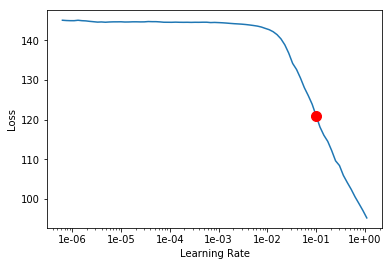

In [11]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [12]:
learn.fit_one_cycle(50, max_lr = 1e-02)

epoch,train_loss,valid_loss,exp_rmspe,time
0,143.424591,143.856918,0.999994,00:00
1,142.144775,139.992996,0.999992,00:00
2,139.396240,129.774567,0.999986,00:00
3,131.992874,104.626984,0.999956,00:00
4,113.611809,49.506668,0.995645,00:00
5,81.554726,9.666736,237.378128,00:00
6,53.830875,4.404423,13.986027,00:00
7,35.524986,0.393772,0.581837,00:00
8,23.498495,0.172593,0.577906,00:00
9,15.625791,0.188475,0.651309,00:00


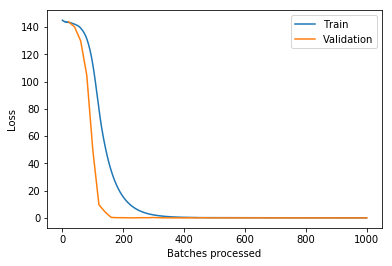

In [13]:
learn.recorder.plot_losses()

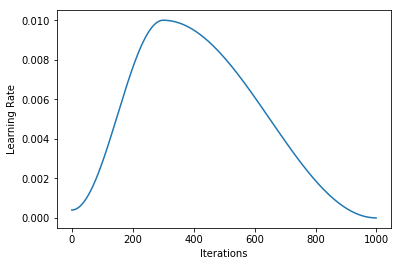

In [14]:
learn.recorder.plot_lr()

# Get predictions

In [15]:
preds, targets = learn.get_preds(ds_type=DatasetType.Test)

In [17]:
final_preds  = np.expm1(preds[:,0].numpy())
final_preds

array([1.146877e+05, 1.653239e+05, 1.814952e+05, 1.949858e+05, ..., 8.876735e+04, 1.536513e+05, 3.554286e+15,
       2.034369e+05], dtype=float32)

In [18]:
sub['SalePrice'] = final_preds
sub.head()

,SalePrice
Id,
1461,114687.695312
1462,165323.906250
1463,181495.156250
1464,194985.765625
1465,194458.187500


In [19]:
sub.to_csv('data/sub_fastaiv1.csv', header=True, index=True)